In [1]:
#General imports
import copy
import gensim
import gensim.downloader as gloader
import matplotlib.pyplot as plt
import numpy as np  
import os  
import pandas as pd  
import random
import re
import seaborn as sb
import sys 
from tqdm import tqdm
from typing import Iterable, List, Dict, Tuple, Set
import urllib.request  
import zipfile  

#sklearn and tensorflow imports
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, Embedding, GRU, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [2]:
#fixed seeds to get reproducible results
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

#Bulding the dataframe

## Dataset download and extraction

In [3]:
DATASET_NAME = "dataset.zip"
DATASET_FOLDERNAME = "Dataset"
DATASET_SUBFOLDER = "dependency_treebank/"
SPLIT_DISTRIBUTION = [100, 150, 199]  #indeces to split in train, validation and test. 

working_folder = os.getcwd()

print("Current working directory: " + str(working_folder))

dataset_folder = os.path.join(os.getcwd(), DATASET_FOLDERNAME)

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

dataset_path = os.path.join(dataset_folder, "dataset.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_folder)
    print("Successful extraction")

dataset_folder = os.path.join(dataset_folder, DATASET_SUBFOLDER)

Current working directory: /content
Successful download
Successful extraction


In [4]:
print(dataset_folder)

/content/Dataset/dependency_treebank/


## Dataframe construction

In [5]:
def encode_dataset(dataset_folder: str, 
                   split_dist: list(), ) -> Dict[str,pd.DataFrame]:
    """
    Encode the dataset into three dataframes, returned in a dict.

    :param 
        - dataset_folder: folder of the extracted dataset
        - split_dist: list of indeces to be used to split in train, validation and test

    :return
        - df_dict: dictionary of train, validation and test dataframes
    """
    
    #dictionary of dataframes to return
    df_dict = {"train": pd.DataFrame(columns=['sentence', 'labels']),
                "val": pd.DataFrame(columns=['sentence', 'labels']),
                "test":pd.DataFrame(columns=['sentence', 'labels'])}
    split = ""

    for filename in sorted(os.listdir(dataset_folder)): #files are read following the order
        file_path = os.path.join(dataset_folder, filename)
        try:
            if os.path.isfile(file_path):
                with open(file_path, mode='r', encoding='utf-8') as text_file:
                    # read it and extract 
                    document_number = filename.split("_")[1].split(".")[0]

                    if int(document_number) <= split_dist[0]:  #find the split the file belongs to
                        split = "train"
                    elif split_dist[0] < int(document_number) <= split_dist[1]:
                        split = "val"
                    else:
                        split = "test"

                    df_file = pd.read_table(
                        file_path, 
                        delimiter='\t', 
                        names=['word', 'label'], 
                        usecols=[0,1],
                        skip_blank_lines=False)
                    
                    #splitting file content in sentences
                    idx = list(df_file.loc[df_file.isnull()['word']].index) #sentences are divided by a blank line, interpreted as a null value. 
                    idx.append(len(df_file))
                    prev = 0
                    for sep in idx:    #to split in sentences, word are read from idx "prev" to "sep", which is why we add len(df_file) to the list of indeces
                        df_sentence = pd.DataFrame({
                            'sentence': [df_file['word'][prev:sep].to_list()],  #sentence column contains the list of words forming the sentence 
                            'labels': [df_file['label'][prev:sep].to_list()]})  #labels column contains the list of labels associated with the words forming the sentence 
                        df_dict[split] = pd.concat([df_dict[split], df_sentence], ignore_index=True)  #adding the row to the appropriate dataframe (according to the split)
                        prev = sep + 1
                    
        except Exception as e:
            print('Failed to process %s. Reason: %s' % (file_path, e))
            sys.exit(0)

    return df_dict

In [6]:
df_dict = encode_dataset(dataset_folder, SPLIT_DISTRIBUTION)

In [7]:
df_dict["train"].head()

,sentence,labels
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."


In [8]:
df_dict["val"].head()

,sentence,labels
0,"[A, House-Senate, conference, approved, major,...","[DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ..."
1,"[For, the, Agency, for, International, Develop...","[IN, DT, NNP, IN, NNP, NNP, ,, NNS, VBD, $, CD..."
2,"[The, conference, approved, at, least, $, 55, ...","[DT, NN, VBD, IN, JJS, $, CD, CD, IN, JJ, NN, ..."
3,"[The, agreement, on, Poland, contrasts, with, ...","[DT, NN, IN, NNP, VBZ, IN, DT, JJ, NNS, VBG, I..."
4,"[These, fiscal, pressures, are, also, a, facto...","[DT, JJ, NNS, VBP, RB, DT, NN, IN, VBG, DT, NN..."


In [9]:
df_dict["test"].head()

,sentence,labels
0,"[Intelogic, Trace, Inc., ,, San, Antonio, ,, T...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P..."
1,"[The, move, boosts, Intelogic, Chairman, Asher...","[DT, NN, VBZ, NNP, NNP, NNP, NNP, POS, NN, TO,..."
2,"[Mr., Ackerman, already, is, seeking, to, oust...","[NNP, NNP, RB, VBZ, VBG, TO, VB, NNP, NNP, IN,..."
3,"[The, action, followed, by, one, day, an, Inte...","[DT, NN, VBN, IN, CD, NN, DT, NNP, NN, IN, PRP..."
4,"[In, New, York, Stock, Exchange, composite, tr...","[IN, NNP, NNP, NNP, NNP, JJ, NN, NN, ,, NNP, N..."


In [10]:
#Creating x and y starting from dataframe just built

x = {"train": df_dict['train']['sentence'],
     "val": df_dict['val']['sentence'],
     "test": df_dict['test']['sentence']}

y = {"train": df_dict['train']['labels'],
     "val": df_dict['val']['labels'],
     "test": df_dict['test']['labels']}

# Glove Embedding model, vocabulary and OOV detection

## Load Glove embedding

We will start using embedding_dimension=50 to speed up the process. Anyway, at the end of this notebook we will move to embedding_dimension=300 to improve results

In [11]:
def load_GloVe_embedding(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [12]:
EMBEDDING_DIMENSION = 50
glove_emb_model = load_GloVe_embedding(EMBEDDING_DIMENSION)

[==================================================] 100.0% 66.0/66.0MB downloaded


##Creating initial vocabulary

In [13]:
from collections import OrderedDict

def build_vocabulary(sr: pd.Series) -> List[str]:
    """
    Given a series of sentences, so a series of list of words, builds the corresponding vocabulary.

    :param sr: series of sentences, so a a series of list of words (pandas.Series)
    :return:
      - vocabulary: set of unique terms that build up the vocabulary (list)
    """
    vocabulary = []
    for sentence in sr:
        for token in sentence:
            if token not in vocabulary:
                vocabulary.append(token)

    return vocabulary

In [14]:
vocabulary_dict = {}  #dict containing the vocabulary of every split (train, validation, test)
for split in df_dict.keys():
    vocabulary_dict[split] = build_vocabulary(x[split])
    print(f'[Debug] {split} vocabulary size: {len(vocabulary_dict[split])}')

[Debug] train vocabulary size: 8009
[Debug] val vocabulary size: 5892
[Debug] test vocabulary size: 3623


## OOV detection

In [15]:
def check_OOV_terms(vocabulary: Iterable[str],
                    word_listing: List[str])  -> List[str]:
    """
    Checks differences between two vocabularies

    :param 
        - vocabulary: vocabulary to which the second one must be compared against 
        - word_listing: dataset specific vocabulary (list)

    :return
        - oov: list of unique OOV terms (terms in word_listing that are not in vocabulary)
    """
    embedding_vocabulary = set(vocabulary)
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [16]:
OOV1 = check_OOV_terms(glove_emb_model.vocab.keys(), vocabulary_dict["train"])  #initial vocabulary is the GloVe one, the other is the train one
OOV1_percentage = float(len(OOV1)) * 100 / len(vocabulary_dict["train"])
print(f"Total OOV terms: {len(OOV1)} ({OOV1_percentage:.2f}%)")

Total OOV terms: 2346 (29.29%)


There are many OOV terms, but we have not done any pre-processing yet. Indeed, a straight forward one is to adopt the same case as Glove. Indeed, we have changed every word to lowercase and looked again for OOV.

In [17]:
OOV1_lowercase = check_OOV_terms(glove_emb_model.vocab.keys(), [v.lower() for v in vocabulary_dict["train"]])
OOV1_lowercase_percentage = float(len(OOV1_lowercase)) * 100 / len(vocabulary_dict["train"])
print(f"Total OOV terms: {len(OOV1_lowercase)} ({OOV1_lowercase_percentage:.2f}%)")

Total OOV terms: 359 (4.48%)


Indeed, just moving to lowercase we have dramatically decreased the number of OOV of train vocabulary versus GloVe vocabulary. 

Now, we have to inspect the remaining OOV words to see which further preprocessing can be useful.

In [18]:
print("\n".join(OOV1_lowercase))

two-sevenths
rexinger
chemplus
dead-eyed
index-related
small-company
electric-utility
bellringers
cotran
sub-markets
we-japanese
limited-partnership
2,303,328
page-one
737.5
pre-1933
six-bottle
374.20
one-country
identity-management
year-ago
3.253
sogo-shosha
school-board
highest-pitched
pathlogy
makato
video-viewing
trettien
money-center
stirlen
143.93
year-earlier
collective-bargaining
preparatives
beer-belly
energy-services
pre-1917
shirt-sleeved
352.7
money-fund
equal-opportunity
70-a-share
bridgestone\/firestone
state-supervised
index-arbitrage
besuboru
secilia
iran\/contra
amphobiles
1.8415
ghkm
unenticing
test-practice
durable-goods
pennview
superpremiums
univest
sub-segments
12,252
anti-china
junk-bond
ensrud
mehrens
520-lawyer
northy
anti-abortionists
side-crash
pianist-comedian
low-ability
purhasing
62%-owned
tarwhine
lezovich
student-test
meinders
old-house
rubinfien
5.276
3057
bermuda-based
chilver
deposits-a
2645.90
church-goers
sometimes-exhausting
stock-manipulation
415.

Printing the whole list of OOV words, we have the following types of OOV words:

*   **Compound words**: in most of the cases they are composed by words that are in the vocabulary
*   **Decimal numbers**: they need to be defined as class, simply because it is not realistic to encode all decimal numbers (they are too many)
*   **Rational numbers**: e.g. 1\/4 , they are similar to decimal numbers. Note that they have a backslash that will be removed to bring them to the standard form of rational numbers. Similarly for compound words separated by "\/" instead of "-" we will perform a replacement
*   **Brackets**: instead of being represented with their symbols like the rest of punctuation, their acronym is use (e.g. -lcb- stands for "left curly bracket")




# Preprocessing
To further reduce the number of OOV words, we will perform the following preprocessing steps:



1.   Change all the words to lowercase
2.   Replace \\/ with /
3.   Replace left bracket symbols
4.   Replace right bracket symbols
5.   Replace rational numbers with "#number#" placeholder
6.   Replace decimal numbers with "#number#" placeholder
7.   Replace compound words' separator: compound words previously separated by "\\/" are separated by "/" after performing step 2., so now we will replace "/" with "-"







In [19]:
def preprocessing(content_list: List[str]) -> List[str]:
    """
    Preprocess a list a strings: applied to every sentence (a sentence is a list of words) 

    :param 
        - content_list: list of string to be preprocessed 

    :return
        - content_list_preprocessed: preprocessed list
    """

    placeholder = "#number#"
    re_slashes = re.compile('\\\/')  #pattern \/ 
    re_rational = re.compile('\d+\/\d+')  #pattern rational number (e.g. 1/5)
    re_number = re.compile('[+-]?(\d*[.])\d+')  #pattern decimal number (e.g. 3.14)
    re_left_bracket = re.compile('(-lrb-)|(-lcb-)')  #pattern left bracket
    re_right_bracket = re.compile('(-rrb-)|(-rcb-)')  #pattern right bracket
    re_slashed_words = re.compile("(\w*)\/(\w*)")  #a slash separating words will be replaced with a dash, following the trend of the dataset, where composed words are in the form word-word

    content_list_preprocessed = [content.lower() for content in content_list]  #change to lowercase
    content_list_preprocessed = [re_slashes.sub("/", content) for content in content_list_preprocessed] #replace \/ with /
    content_list_preprocessed = [re_left_bracket.sub("(", content) for content in content_list_preprocessed]  #replace left bracket symbols
    content_list_preprocessed = [re_right_bracket.sub(")", content) for content in content_list_preprocessed]  #replace right bracket symbols
    content_list_preprocessed = [placeholder if re.match(re_rational, content) else content for content in content_list_preprocessed]  #replace rational numbers with a placeholder
    content_list_preprocessed = [placeholder if re.match(re_number, content) else content for content in content_list_preprocessed]  #replace decimal numbers with a placeholder
    content_list_preprocessed = [content.replace("/", "-") if re.match(re_slashed_words, content) else content for content in content_list_preprocessed]  #replace compound words' separator 

    return content_list_preprocessed

Preprocessing the training set

In [20]:
x_train_preprocessed = x["train"].apply(preprocessing)

Building the new vocabulary after preprocessing

In [21]:
train_vocabulary_preprocessed = build_vocabulary(x_train_preprocessed)
print(f'[Debug] train vocabulary size after preprocessing: {len(train_vocabulary_preprocessed)}')

OOV1_preprocessed = check_OOV_terms(glove_emb_model.vocab.keys(), train_vocabulary_preprocessed)
OOV1_preprocessed_percentage = float(len(OOV1_preprocessed)) * 100 / len(train_vocabulary_preprocessed)
print(f"Total OOV terms after preprocessing: {len(OOV1_preprocessed)} ({OOV1_preprocessed_percentage:.2f}%)")

[Debug] train vocabulary size after preprocessing: 7214
Total OOV terms after preprocessing: 318 (4.41%)


It can be seen that the number of OOV words has decreased with respect to the the non preprocessed data. Also note that many oov words are compound ones, for which a specific embedding will be created (see Embedding Matrix section).

Similarly to train data, we apply preprocessing to validation and test splits.

In [22]:
x_pre = {"train": x_train_preprocessed,
        "val": x["val"].apply(preprocessing),
        "test": x["test"].apply(preprocessing)}

# Vocabulary creation and encoding
We will create the complete vocabulary starting from an empty one, then adding sequencially GloVe, train, validation and test vocabularies.  

Then we will map words and labels (part of speech) to numbers, following the mapping built with the vocabulary.

In [23]:
def extend_vocabulary(word_to_idx_original: Dict[str, int],
                      words_to_add: List[str]) -> Tuple[Dict[str, int],Dict[int, str]]:
  """
    Given a mapping between word and indeces, it adds oov words at the end of the dictionary.
    Note that this method can be used also to create a word_to_id vocabulary mapping from scratches: word_to_idx_original will be an empty dict, words_to_add the list of the starting words (for us GloVe vocabulary)

    :param 
        - word_to_idx_original: dictionary with key=word and value=index to which the word is mapped
        - words_to_add: list of words to compare with word_to_idx_original. If a word is not found, then it must be inserted in the dictionary
    :return:
        - word_to_idx_extended: word_to_idx with new words
        - idx_to_word_extended: swapped version of word_to_idx_extended (keys and values are swapped)
  """
  word_to_idx_extended = copy.deepcopy(word_to_idx_original)  #deep copy is needed, otherwise python does not create a copy but only a reference to the already existing object, thus reflecting changes on both
  idx = len(word_to_idx_extended.keys())
  if idx == 0: 
    idx = 1  #position 0 is reserved

  for sentence in words_to_add:
      for token in sentence:
          if token not in word_to_idx_extended:
              word_to_idx_extended[token] = idx 
              idx += 1
  idx_to_word_extended = {v: k for k, v in word_to_idx_extended.items()}

  return word_to_idx_extended, idx_to_word_extended

def encode_into_numbers(sentences: List[List[str]],
                        word_to_idx_mapping: Dict[str, int]) -> List[List[int]]:
    """
    Encode every word of every sentence into an integer following the word mapping

    :param 
        - sentences: sentences whose words have to be encoded into numbers following word_to_idx_mapping (list of list of strings)
        - word_to_idx_mapping: dictionary with key=word and value=index to which the word is mapped
    :return:
        - encoded_data: sentences'encoding (list of list of integers)
    """
    encoded_data = [[word_to_idx_mapping[token] for token in sentence] for sentence in sentences]
 
    return encoded_data

def decode_into_words(encoded_sentences: List[List[int]],
                        idx_to_word_mapping: Dict[int,str]) -> List[List[str]]:
    """
    Reverse the encoding, replacing numbers encodings with the corresponding word

    :param 
        - encoded_sentences: sentences to decode following idx_to_word_mapping (list of list of integers)
        - idx_to_word_mapping: dictionary with key=index and value=word
    :return:
        - decoded_data: sentences'encoding (list of list of strings)
    """
    decoded_data = [[idx_to_word_mapping[index] for index in sentence] for sentence in encoded_sentences]
 
    return decoded_data

In the following cells we create the vocabulary mappings and then encode the words.

Note that word_to_idx and idx_to_word mappings are incremental, this means that the validation vocabulary includes the train one, and the test one includes train and validation ones. This has been made according to the guidelines on the construction of V1, V2, V3, V4. All in all, the complete vocabulary is the one with _test suffix.

Furthermore, in the embedding section the intermediate vocabularies will be used according to what they contain. For example, to compute the embedding matrix on the train set, we will use word_to_idx_train, while for validation word_to_idx_val, always proceeding in an incremental way.

In [24]:
# Train mappings
word_to_idx_train, idx_to_word_train = extend_vocabulary({}, [glove_emb_model.vocab.keys()] + x_pre["train"].tolist())
print("Train vocabulary size: ", len(word_to_idx_train))

# Validation mappings
word_to_idx_val, idx_to_word_val = extend_vocabulary(word_to_idx_train, x_pre["val"].tolist())
print("Validation vocabulary size: ", len(word_to_idx_val))

# Test mappings
word_to_idx_test, idx_to_word_test = extend_vocabulary(word_to_idx_val, x_pre["test"].tolist())
print("Test vocabulary size: ", len(word_to_idx_test))

# x_enc is the dictionary containing preprocessed data which have been encoded
# In the end, for evry split we will move from a list of list of words to a list of list of numbers
x_enc = {"train": encode_into_numbers(x_pre["train"].tolist(), word_to_idx_train),
        "val": encode_into_numbers(x_pre["val"].tolist(), word_to_idx_val),
        "test": encode_into_numbers(x_pre["test"].tolist(), word_to_idx_test)}

Train vocabulary size:  400318
Validation vocabulary size:  400475
Test vocabulary size:  400571


Encoding parts of speech. Clearly, pos' mappings are different from words' ones and must be kept separated, so we create another mapping from labels to numbers and viceversa.

In [25]:
# creating vocabulary mapping for the labels in the whole dataset
label_to_idx, idx_to_label = extend_vocabulary({},  y["train"].tolist() + y["val"].tolist() + y["test"].tolist())

number_pos = len(label_to_idx)
print(f"In the dataset there are {number_pos} distinct POS")

y_enc = {"train": encode_into_numbers(y["train"].tolist(), label_to_idx),
        "val": encode_into_numbers(y["val"].tolist(), label_to_idx),
        "test": encode_into_numbers(y["test"].tolist(), label_to_idx)}

In the dataset there are 45 distinct POS


Let's look at the sentencese to see if our pipeline is working as expected.

In [26]:
example = np.random.randint(0, len(x_enc["train"]))
print(f"Original sentence")
print(x["train"][example])
print("\nPreprocessed sentence")
print([x_pre["train"][example]][0])
print("\nEncoded sentence")
print([x_enc["train"][example]][0])
print("\nDecoded sentence")
print(decode_into_words([x_enc["train"][example]], idx_to_word_train)[0])

Original sentence
['From', 'an', 'advertising', 'standpoint', ',', 'the', 'problem', 'is', 'these', 'offenders', 'are', 'likely', 'to', 'be', 'some', 'of', 'the', 'same', 'folks', 'that', 'are', 'major', 'magazine', 'advertisers', 'these', 'days', '.']

Preprocessed sentence
['from', 'an', 'advertising', 'standpoint', ',', 'the', 'problem', 'is', 'these', 'offenders', 'are', 'likely', 'to', 'be', 'some', 'of', 'the', 'same', 'folks', 'that', 'are', 'major', 'magazine', 'advertisers', 'these', 'days', '.']

Encoded sentence
[26, 30, 2554, 15295, 2, 1, 748, 15, 159, 8982, 33, 648, 5, 31, 78, 4, 1, 216, 6230, 13, 33, 225, 1231, 10332, 159, 250, 3]

Decoded sentence
['from', 'an', 'advertising', 'standpoint', ',', 'the', 'problem', 'is', 'these', 'offenders', 'are', 'likely', 'to', 'be', 'some', 'of', 'the', 'same', 'folks', 'that', 'are', 'major', 'magazine', 'advertisers', 'these', 'days', '.']


It can be seen that we are moving from the original sentence to its encoded version correctly, as decoding it we obtain the original one again (a part from the differences introduced by the irreversible preprocessing)

The exact same considerations hold for pos tags, as shown in the example below.

In [27]:
example = np.random.randint(0, len(y_enc["train"]))
print(f"Original labels")
print(y["train"][example])
print("\nEncoded labels")
print([y_enc["train"][example]][0])
print("\nDecoded labels")
print(decode_into_words([y_enc["train"][example]], idx_to_label)[0])

Original labels
['DT', 'JJ', 'NNS', 'VBP', 'JJ', 'JJ', 'NNP', 'NNS', 'IN', 'JJ', 'NNS', 'CC', 'NNS', ',', 'RB', 'VBG', 'PRP$', 'NN', 'IN', 'NNS', 'IN', 'JJ', 'NNS', 'MD', 'RB', 'VB', '.']

Encoded labels
[8, 5, 4, 22, 5, 5, 1, 4, 10, 5, 4, 14, 4, 2, 17, 13, 24, 9, 10, 4, 10, 5, 4, 6, 17, 7, 11]

Decoded labels
['DT', 'JJ', 'NNS', 'VBP', 'JJ', 'JJ', 'NNP', 'NNS', 'IN', 'JJ', 'NNS', 'CC', 'NNS', ',', 'RB', 'VBG', 'PRP$', 'NN', 'IN', 'NNS', 'IN', 'JJ', 'NNS', 'MD', 'RB', 'VB', '.']


# Embedding matrix

In order to create the embdedding matrix we decided to handle compound words' embeddings in the following way: 


1.   Split on the dash ("-")
1.   Order the obtained words by length  
2.   Try to get their embeddings starting from the longest word and going on until an embdedding is retrieved or all the subwords have been tried (which means that all the subwords are not in GloVe)
3. If an embedding is found, use it as the compound word's one. If it is not found, assign a random embedding to the compund word.

in addition, for non-compound words that are not in GloVe, we directly assign a random embedding.

In [28]:
def get_dashed_embeddings(embedding_model: gensim.models.keyedvectors.KeyedVectors, 
                          word: str) -> float:
  """
    Given an embedding_model and a word it returns its "dashed embedding" if the word contains a dash, None otherwise.
    We defined dashed embeddings as the embedding of the longest word found in the embedding model.

    :param 
        - embedding_model: embedding_model to be used
        - words_to_add: list of words to compare with word_to_idx_original. If a word is not found, then it must be inserted in the dictionary
    :return:
        - embedding of the longest word in the compound one if it contains a dash and an embedding is found. Else, return None
  """
  if "-" in word:
    words_split = word.split("-")
    words_split.sort(key=len)  #getting the encoding of compound words starting from the longest one
    for word_piece in words_split:
      try:
        return embedding_model[word]  #if a word is found, assign its embedding to the matrix element
      except:
        pass  #if the current word is not found, do nothing and try the next one
  return None  # None is returned if the word does not contain a dash or if all the words in the compound one are not contained in the embedding model

def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int]) -> np.ndarray:
    """
    Builds the embedding matrix starting from a pre-trained word embedding model

    :param 
        - embedding_model: pre-trained word embedding model (gensim wrapper)
        - embedding_dimension: dimension of the embedding
        - word_to_idx: dictionary with key=word and value=index to which the word is mapped

    :return
        - embedding matrix
    """
    embedding_matrix = np.zeros((len(word_to_idx)+1, embedding_dimension), dtype=np.float32)
    
    #adding all GloVe vocabularies embeddings
    for word, idx in word_to_idx.items():
      if word in embedding_model:
          embedding_matrix[idx] = embedding_model[word]
      else: 
          dashed_embedding = get_dashed_embeddings(embedding_model, word)
          if dashed_embedding is None: #it means that word has no dash or all its subwords are oov
              dashed_embedding = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
          embedding_matrix[idx] = dashed_embedding
 
    return embedding_matrix


#This functions adds the embedding of OOV words to the embedding matrix. Note that it directly tries to find an embedding for dashed words and if none is retrieved it uses a uniform random distribution
def extend_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                            embedding_matrix: np.ndarray,
                            word_to_idx: Dict[str, int]) -> np.ndarray:
    """
    Extend an embedding matrix adding words in word_to_idx that are oov

    :param 
        - embedding_model: pre-trained word embedding model (gensim wrapper)
        - embedding_matrix: starting embedding matrix
        - word_to_idx: word mapping from which oov words must be retrieved

    :return
        - new embedding matrix: concatenation of the previous embedding matrix with the one of oov terms
    """

    oov_terms = [key for key, idx in word_to_idx.items() if idx >= embedding_matrix.shape[0]] #all the terms mapped to an index greater than the vocabulary size (number of rows) are not in the embedding matrix 
    oov_embedding_matrix = np.zeros((len(oov_terms), embedding_matrix.shape[1]), dtype=np.float32)
    
    for idx, oov in enumerate(oov_terms):
        dashed_embedding = get_dashed_embeddings(embedding_model, oov)
        if dashed_embedding is None: #it means that word has no dash or all its subwords are oov
            dashed_embedding = np.random.uniform(low=-0.05, high=0.05, size=embedding_matrix.shape[1])

        oov_embedding_matrix[idx] = dashed_embedding

    return np.concatenate([embedding_matrix, oov_embedding_matrix], axis=0)

In [29]:
embedding_matrix = build_embedding_matrix(glove_emb_model, 
                                          EMBEDDING_DIMENSION,
                                          word_to_idx_train)
print(f"Embedding matrix with GloVe and train vocabulary has shape: {embedding_matrix.shape}")

embedding_matrix = extend_embedding_matrix(glove_emb_model, 
                                          embedding_matrix,
                                          word_to_idx_val)
print(f"Embedding matrix after the extension with validation oov words has shape: {embedding_matrix.shape}")

embedding_matrix = extend_embedding_matrix(glove_emb_model, 
                                          embedding_matrix,
                                          word_to_idx_test)
print(f"Embedding matrix after the extension with test oov words has shape: {embedding_matrix.shape}")

Embedding matrix with GloVe and train vocabulary has shape: (400319, 50)
Embedding matrix after the extension with validation oov words has shape: (400475, 50)
Embedding matrix after the extension with test oov words has shape: (400571, 50)


# Sequence length standardization 
Every sentence must have the same length as the others in the same split, otherwise we would hade different input sizes for the model. For this reason we are going to pad all the encoded sentences, adding the needed number of zeros at the end of each sentence. As a result, we are introducing another label (0) which is related to padding. For this purpose previously we forced the mapping to start from index 1. 

In addition, we encoded the labels using categorical representation (one-hot-encoding).

In [30]:
max_length_dict = {"train": len(max(x_enc["train"], key=len)),
                   "val": len(max(x_enc["val"], key=len)),
                   "test": len(max(x_enc["test"], key=len))}

number_pos = len(label_to_idx) + 1 #to add the padding
x_st, y_st, y_cat = {}, {}, {}

for key in max_length_dict.keys():
    x_st[key] = pad_sequences(x_enc[key], maxlen=max_length_dict[key], padding='post')  #add 0s at the end to reach max_length
    y_st[key] = pad_sequences(y_enc[key], maxlen=max_length_dict[key], padding='post')  #add 0s at the end to reach max_length
    y_cat[key] = to_categorical(y_st[key], num_classes=number_pos)  #one-hot-encoding the labels

In [31]:
print(max_length_dict)

{'train': 249, 'val': 81, 'test': 58}


# Models
In this section we will build the four models indicated in the assignment. Each of them has its section.

All the models are stored in "models" dicitionary, in correspondance of key=model_name. The same happens for their histories, sotred in "history" dict.

In [32]:
models = {}
history = {}
batch_size = 16
epochs = 30
units = 100

## Baseline model

In [33]:
def build_baseline_model(num_pos, 
                        embedding_matrix, 
                        name = 'baseline',
                        units=units):
  inputs = Input(shape=(None,), dtype="int32")
  
  m = Embedding(input_dim=embedding_matrix.shape[0], 
                output_dim=embedding_matrix.shape[1],
                mask_zero=True, 
                weights=[embedding_matrix], 
                trainable=False)(inputs)

  m = Bidirectional(LSTM(units=units, return_sequences=True))(m)

  m = Dense(num_pos, activation='softmax')(m)
  return Model(inputs, m, name=name)

In [34]:
models["baseline"] = build_baseline_model(num_pos = number_pos, 
                                          embedding_matrix = embedding_matrix, 
                                          name="baseline")
models["baseline"].summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          20028550  
                                                                 
 bidirectional (Bidirectiona  (None, None, 200)        120800    
 l)                                                              
                                                                 
 dense (Dense)               (None, None, 46)          9246      
                                                                 
Total params: 20,158,596
Trainable params: 130,046
Non-trainable params: 20,028,550
_________________________________________________________________


In [35]:
models['baseline'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

In [36]:
history['baseline'] = models['baseline'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
123/123 [==============================] - 17s 42ms/step - loss: 0.2257 - accuracy: 0.3913 - val_loss: 0.4625 - val_accuracy: 0.5890
Epoch 2/30
123/123 [==============================] - 2s 20ms/step - loss: 0.1168 - accuracy: 0.6865 - val_loss: 0.3069 - val_accuracy: 0.7161
Epoch 3/30
123/123 [==============================] - 4s 36ms/step - loss: 0.0850 - accuracy: 0.7615 - val_loss: 0.2511 - val_accuracy: 0.7609
Epoch 4/30
123/123 [==============================] - 5s 38ms/step - loss: 0.0711 - accuracy: 0.7959 - val_loss: 0.2204 - val_accuracy: 0.7882
Epoch 5/30
123/123 [==============================] - 5s 40ms/step - loss: 0.0624 - accuracy: 0.8187 - val_loss: 0.2019 - val_accuracy: 0.8061
Epoch 6/30
123/123 [==============================] - 5s 37ms/step - loss: 0.0563 - accuracy: 0.8355 - val_loss: 0.1877 - val_accuracy: 0.8161
Epoch 7/30
123/123 [==============================] - 5s 42ms/step - loss: 0.0515 - accuracy: 0.8482 - val_loss: 0.1772 - val_accuracy: 0.825

In [37]:
models["baseline"].save_weights('./baseline.h5')

## Baseline with GRU instead of LSTM

In [38]:
def build_baseline_model_with_GRU(num_pos, 
                        embedding_matrix, 
                        name = 'baseline_with_GRU',
                        units=units):
  inputs = Input(shape=(None,), dtype="int32")
  
  m = Embedding(input_dim=embedding_matrix.shape[0], 
                output_dim=embedding_matrix.shape[1],
                mask_zero=True, 
                weights=[embedding_matrix], 
                trainable=False)(inputs)

  m = Bidirectional(GRU(units=units, return_sequences=True))(m)

  m = Dense(num_pos, activation='softmax')(m)
  return Model(inputs, m, name=name)

In [39]:
models["baseline_with_GRU"] = build_baseline_model_with_GRU(num_pos = number_pos, 
                                          embedding_matrix = embedding_matrix, 
                                          name="baseline_with_GRU")
models["baseline_with_GRU"].summary()

Model: "baseline_with_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 50)          20028550  
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 200)        91200     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, None, 46)          9246      
                                                                 
Total params: 20,128,996
Trainable params: 100,446
Non-trainable params: 20,028,550
_________________________________________________________________


In [40]:
models['baseline_with_GRU'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

In [41]:
history['baseline_with_GRU'] = models['baseline_with_GRU'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
123/123 [==============================] - 13s 49ms/step - loss: 0.1954 - accuracy: 0.4845 - val_loss: 0.3601 - val_accuracy: 0.6745
Epoch 2/30
123/123 [==============================] - 4s 32ms/step - loss: 0.0917 - accuracy: 0.7467 - val_loss: 0.2492 - val_accuracy: 0.7636
Epoch 3/30
123/123 [==============================] - 3s 25ms/step - loss: 0.0692 - accuracy: 0.8006 - val_loss: 0.2117 - val_accuracy: 0.7940
Epoch 4/30
123/123 [==============================] - 3s 24ms/step - loss: 0.0587 - accuracy: 0.8264 - val_loss: 0.1868 - val_accuracy: 0.8164
Epoch 5/30
123/123 [==============================] - 2s 20ms/step - loss: 0.0515 - accuracy: 0.8460 - val_loss: 0.1716 - val_accuracy: 0.8306
Epoch 6/30
123/123 [==============================] - 2s 19ms/step - loss: 0.0461 - accuracy: 0.8616 - val_loss: 0.1594 - val_accuracy: 0.8403
Epoch 7/30
123/123 [==============================] - 2s 20ms/step - loss: 0.0417 - accuracy: 0.8747 - val_loss: 0.1501 - val_accuracy: 0.849

In [42]:
models["baseline_with_GRU"].save_weights('./baseline_with_GRU.h5')

## Baseline with an additional LSTM

In [43]:
def build_baseline_model_with_additional_LSTM(num_pos, 
                        embedding_matrix, 
                        name = 'baseline_with_2_LSTM',
                        units=units):
  inputs = Input(shape=(None,), dtype="int32")
  
  m = Embedding(input_dim=embedding_matrix.shape[0], 
                output_dim=embedding_matrix.shape[1],
                mask_zero=True, 
                weights=[embedding_matrix], 
                trainable=False)(inputs)

  m = Bidirectional(LSTM(units=units, return_sequences=True))(m)
  m = LSTM(units=units, return_sequences=True)(m)
  m = Dense(num_pos, activation='softmax')(m)
  return Model(inputs, m, name=name)

In [44]:
models["baseline_with_2_LSTM"] = build_baseline_model_with_additional_LSTM(num_pos = number_pos, 
                                          embedding_matrix = embedding_matrix, 
                                          name="baseline_with_2_LSTM")
models["baseline_with_2_LSTM"].summary()

Model: "baseline_with_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 50)          20028550  
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 200)        120800    
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, None, 100)         120400    
                                                                 
 dense_2 (Dense)             (None, None, 46)          4646      
                                                                 
Total params: 20,274,396
Trainable params: 245,846
Non-trainable params: 20,028,550
____________________________

In [45]:
models['baseline_with_2_LSTM'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

In [46]:
history['baseline_with_2_LSTM'] = models['baseline_with_2_LSTM'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
123/123 [==============================] - 18s 61ms/step - loss: 0.2484 - accuracy: 0.2969 - val_loss: 0.5381 - val_accuracy: 0.5076
Epoch 2/30
123/123 [==============================] - 4s 29ms/step - loss: 0.1342 - accuracy: 0.6215 - val_loss: 0.3450 - val_accuracy: 0.6786
Epoch 3/30
123/123 [==============================] - 3s 28ms/step - loss: 0.0929 - accuracy: 0.7405 - val_loss: 0.2652 - val_accuracy: 0.7494
Epoch 4/30
123/123 [==============================] - 4s 34ms/step - loss: 0.0739 - accuracy: 0.7897 - val_loss: 0.2236 - val_accuracy: 0.7858
Epoch 5/30
123/123 [==============================] - 4s 36ms/step - loss: 0.0623 - accuracy: 0.8193 - val_loss: 0.1978 - val_accuracy: 0.8124
Epoch 6/30
123/123 [==============================] - 4s 29ms/step - loss: 0.0539 - accuracy: 0.8447 - val_loss: 0.1793 - val_accuracy: 0.8244
Epoch 7/30
123/123 [==============================] - 3s 28ms/step - loss: 0.0475 - accuracy: 0.8619 - val_loss: 0.1654 - val_accuracy: 0.837

In [47]:
models["baseline_with_2_LSTM"].save_weights('./baseline_with_2_LSTM.h5')

## Baseline with an additional Dense layer

In [48]:
def build_baseline_model_with_additional_Dense(num_pos, 
                        embedding_matrix, 
                        name = 'baseline_with_2_Dense',
                        units=units):
  inputs = Input(shape=(None,), dtype="int32")
  
  m = Embedding(input_dim=embedding_matrix.shape[0], 
                output_dim=embedding_matrix.shape[1],
                mask_zero=True, 
                weights=[embedding_matrix], 
                trainable=False)(inputs)

  m = Bidirectional(LSTM(units=units, return_sequences=True))(m)
  m = Dense(100, activation='relu')(m)
  m = Dense(num_pos, activation='softmax')(m)
  return Model(inputs, m, name=name)

In [49]:
models["baseline_with_2_Dense"] = build_baseline_model_with_additional_Dense(num_pos = number_pos, 
                                          embedding_matrix = embedding_matrix, 
                                          name="baseline_with_2_Dense")
models["baseline_with_2_Dense"].summary()

Model: "baseline_with_2_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 50)          20028550  
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 200)        120800    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, None, 100)         20100     
                                                                 
 dense_4 (Dense)             (None, None, 46)          4646      
                                                                 
Total params: 20,174,096
Trainable params: 145,546
Non-trainable params: 20,028,550
___________________________

In [50]:
models['baseline_with_2_Dense'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

In [51]:
history['baseline_with_2_Dense'] = models['baseline_with_2_Dense'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
123/123 [==============================] - 15s 51ms/step - loss: 0.2156 - accuracy: 0.4106 - val_loss: 0.3928 - val_accuracy: 0.6353
Epoch 2/30
123/123 [==============================] - 3s 22ms/step - loss: 0.0978 - accuracy: 0.7221 - val_loss: 0.2658 - val_accuracy: 0.7386
Epoch 3/30
123/123 [==============================] - 3s 27ms/step - loss: 0.0719 - accuracy: 0.7885 - val_loss: 0.2203 - val_accuracy: 0.7841
Epoch 4/30
123/123 [==============================] - 5s 40ms/step - loss: 0.0598 - accuracy: 0.8204 - val_loss: 0.1907 - val_accuracy: 0.8102
Epoch 5/30
123/123 [==============================] - 4s 30ms/step - loss: 0.0518 - accuracy: 0.8432 - val_loss: 0.1725 - val_accuracy: 0.8300
Epoch 6/30
123/123 [==============================] - 3s 27ms/step - loss: 0.0456 - accuracy: 0.8624 - val_loss: 0.1617 - val_accuracy: 0.8354
Epoch 7/30
123/123 [==============================] - 3s 25ms/step - loss: 0.0409 - accuracy: 0.8771 - val_loss: 0.1510 - val_accuracy: 0.848

In [52]:
models["baseline_with_2_Dense"].save_weights('./baseline_with_2_Dense.h5')

# Evaluation

## F1 score

To exclude punctuation, we are going to check the content of our label vocabulary. Inside this dictionary we have all the labels used above. Since the goal is to exclude them from f1-score computation, we will create a list of these special pos that will be used at evaluation time.

In [53]:
print(" ".join(label_to_idx.keys()))

NNP , CD NNS JJ MD VB DT NN IN . VBZ VBG CC VBD VBN RB TO PRP RBR WDT VBP RP PRP$ JJS POS `` EX '' WP : JJR WRB $ NNPS WP$ -LRB- -RRB- PDT RBS FW UH SYM LS #


In [54]:
punctuation = [",", ".", '``', "''", ':', '$', '-LRB-','-RRB-','#']
punctuation_enc = encode_into_numbers([punctuation], label_to_idx)[0]
punctuation_enc.append(0) #padding symbol
print(punctuation_enc)

[2, 11, 27, 29, 31, 34, 37, 38, 45, 0]


In [134]:
def compute_f1(model, x, y_true, punctuation, return_length=False):
    """
    Given a model, the data x to feed to the model, the ground truth labels and punctuation encodings, return f1-score

    :param 
        - model: model to be used
        - x: input data (standardized version of the encoded sentences)
        - y_true: ground truth labels (one-hot-encoded)
        - punctuation: punctuation encodings to exclude from f1-score computation
        - return_length: return the number of samples after punctuation remotion
    :return:
        - f1_score with macro average
    """
    y_true = np.argmax(y_true, axis=2).flatten()
    y_pred = np.argmax(model.predict(x), axis=2).flatten()
    
    mask = np.in1d(y_true, punctuation, invert=True)  #mask to exclude punctuation symbols
    unique_pos = [pos for pos in np.unique(y_true) if not pos in punctuation]

    if return_length:
        print(f"Number of samples after masking: {len(y_true[mask])}")
    return f1_score(y_true[mask], 
                    y_pred[mask], 
                    average='macro', 
                    labels=unique_pos, 
                    zero_division=0)

Now we compute f1-score on the validation set for all the models built up to now.

In [56]:
f1_scores = {key: compute_f1(models[key],x_st["val"],y_cat["val"], punctuation_enc) for key in models.keys()}
f1_scores = {k: v for k, v in sorted(f1_scores.items(), key=lambda item: item[1], reverse=True)}  #sort dictionary by f1-score values
print()
for model, score in f1_scores.items():
  print(f"Model {model} f1-score on validation set: {score:.5f}")

41/41 [==============================] - 3s 8ms/step

Model baseline f1-score on validation set: 0.73387
Model baseline_with_GRU f1-score on validation set: 0.73238
Model baseline_with_2_LSTM f1-score on validation set: 0.73069
Model baseline_with_2_Dense f1-score on validation set: 0.72315


According to the f1-score computed on validation set, the best model is the baseline. 

In [57]:
best_model = models[list(f1_scores.keys())[0]]
best_model.name

'baseline'

## History inspection
To better understand how the models are performing, we can use training histories and plot loss and accuracy for all of them. In the first column we can see loss' plots, in the second one the accuracy. There is also a cross gray cross on the point of minimum loss (epoch, loss) and the one of maximum accuracy (epoch, accuracy).

In [60]:
def plot_history(history_dict):
  fig, axes = plt.subplots(nrows=len(history_dict.keys()), ncols=2, figsize=(4*len(history_dict.keys()), 16))
  for idx, model in enumerate(history_dict.keys()):
    model_history = history_dict[model].history

    loss = pd.DataFrame(np.array([model_history['loss'], model_history['val_loss']]).T, columns=['Train', 'Validation'])
    min_loss = loss['Validation'].min()
    min_loss_idx = loss['Validation'].idxmin()
    accuracy = pd.DataFrame(np.array([model_history['accuracy'], model_history['val_accuracy']]).T, columns=['Train', 'Validation'])
    max_acc = accuracy['Validation'].max()
    max_acc_idx = accuracy['Validation'].idxmax()

    sb.lineplot(data=loss, ax=axes[idx][0])
    sb.lineplot(data=accuracy, ax=axes[idx][1])

    axes[idx][0].axhline(min_loss, color='lightgray', linestyle='-')
    axes[idx][0].axvline(min_loss_idx, color='lightgray', linestyle='-')
    axes[idx][1].axhline(max_acc, color='lightgray', linestyle='-')
    axes[idx][1].axvline(max_acc_idx, color='lightgray', linestyle='-')

    axes[idx][0].set_xlabel('Epochs')
    axes[idx][1].set_xlabel('Epochs')
    axes[idx][0].set_ylabel('Loss')
    axes[idx][1].set_ylabel('Accuracy')
    axes[idx][0].set_title(f"{model} loss")
    axes[idx][1].set_title(f"{model} accuracy")

  fig.tight_layout()
  plt.show()

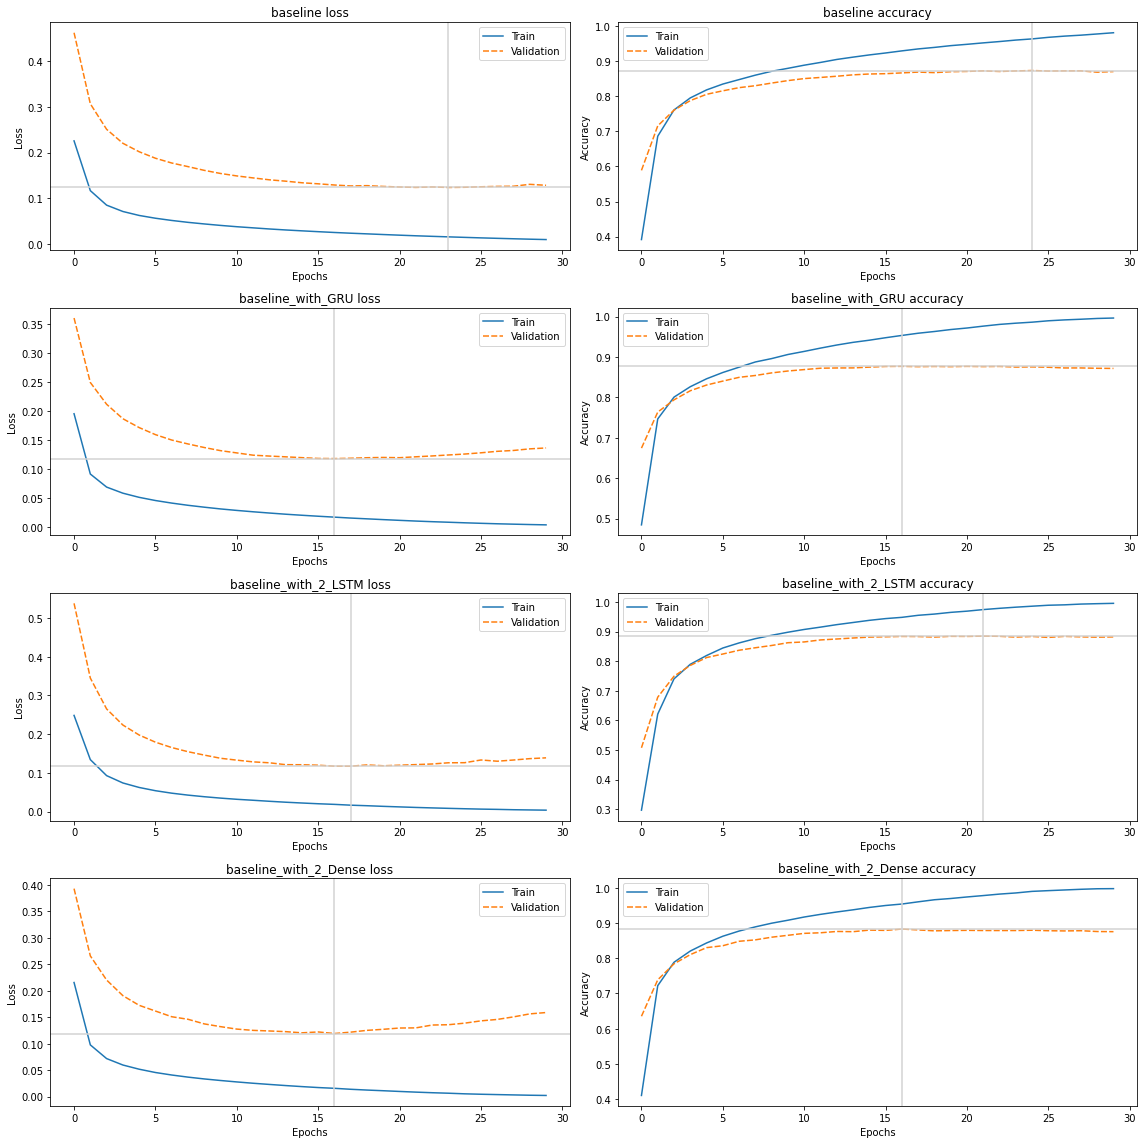

In [61]:
plot_history(history)

The charts show that all the models are overfitting, as they reach the minimum value for validation loss between epoch number 10 and 15. and then it starts increasing again. Accuracy reaches a plateau too. As a result, something to reduce overfitting has to be done in order to improve model performances.

# Improving the best model
The baseline model is the best one up to this point, so we are going to try to improve its performances. 




A straightforward modification is to move to GloVe embedding with size 300, as up to now the one with size 50 has been used. This new embedding is much heavier than the previous one, but is ensures better results. Considering this, all the following models will use the embedding matrix built with this new embedding size.

We are also going to test what happens if we increase to 200 the number of LSTM hidden units, which previously were set to 100. 

Finally, as already pointed out, it is clear that the model starts to overfit, so we will introduce a dropout layer and droput on the LSTM layer to check if it is going to reduce overfitting.

In [62]:
EMBEDDING_DIMENSION_BIGGER = 300
units_bigger = 200
dropout_percentage = 0.2

In [63]:
glove_emb_model_bigger = load_GloVe_embedding(EMBEDDING_DIMENSION_BIGGER)

[==================================================] 100.0% 376.1/376.1MB downloaded


In [64]:
embedding_matrix_bigger = build_embedding_matrix(glove_emb_model_bigger, 
                                                EMBEDDING_DIMENSION_BIGGER,
                                                word_to_idx_train)
print(embedding_matrix_bigger.shape)

embedding_matrix_bigger = extend_embedding_matrix(glove_emb_model_bigger, 
                                                  embedding_matrix_bigger,
                                                  word_to_idx_val)
print(embedding_matrix_bigger.shape)

embedding_matrix_bigger = extend_embedding_matrix(glove_emb_model_bigger, 
                                                  embedding_matrix_bigger,
                                                  word_to_idx_test)
print(embedding_matrix_bigger.shape)

(400319, 300)
(400475, 300)
(400571, 300)


In [65]:
def build_final_model(num_pos, 
                      embedding_matrix, 
                      name = 'final',
                      units = units_bigger, 
                      dropout_layer = True,
                      dropout_LSTM = True,
                      dropout_percentage = dropout_percentage):
  
  """
    Return a model defined according to the parameters.

    :param 
        - num_pos: number of pos labels
        - embedding_matrix: embedding matrix to use in the embedding layer
        - name: model name
        - units: number of LSTM hidden units to use
        - dropout_layer: if True, add a dropout layer between the embedding and the BiLSTM one
        - dropout_LSTM: if True, add dropout to the LSTM layer (using its parameter)
        - dropout_percentage: dropout value to use
    :return:
        - the model
  """
  inputs = Input(shape=(None,), dtype="int32")

  
  m = Embedding(input_dim=embedding_matrix.shape[0], 
                output_dim=embedding_matrix.shape[1],
                mask_zero=True, 
                weights=[embedding_matrix], 
                trainable=False)(inputs)

  if dropout_layer:
    m = Dropout(dropout_percentage)(m)

  if dropout_LSTM:
    m = Bidirectional(LSTM(units=units, return_sequences=True, dropout=dropout_percentage))(m)
  else:
    m = Bidirectional(LSTM(units=units, return_sequences=True))(m)

  m = Dense(num_pos, activation='softmax')(m)

  return Model(inputs, m, name=name)

In [66]:
final_models = {}
final_models_history = {}
final_models_f1_scores = {}

### Final model with more LSTM hidden units, a dropout layer and dropout on LSTM

In [67]:
final_models['units_bigger-dropout_layer-dropout_LSTM'] = build_final_model(num_pos = number_pos, 
                                embedding_matrix = embedding_matrix_bigger, 
                                name = "units_bigger-dropout_layer-dropout_LSTM",
                                units = units_bigger,
                                dropout_layer = True,
                                dropout_LSTM = True,
                                dropout_percentage = dropout_percentage) 

In [68]:
final_models['units_bigger-dropout_layer-dropout_LSTM'].summary()

Model: "units_bigger-dropout_layer-dropout_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 300)         120171300 
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 400)        801600    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, None, 46)          18446     
                                                                 
Total params: 120,991,346
Trainable params: 820,046
Non-trainable params: 120,171,300
_______

In [69]:
final_models['units_bigger-dropout_layer-dropout_LSTM'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])
final_models_history['units_bigger-dropout_layer-dropout_LSTM'] = final_models['units_bigger-dropout_layer-dropout_LSTM'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
123/123 [==============================] - 14s 49ms/step - loss: 0.1463 - accuracy: 0.6089 - val_loss: 0.2148 - val_accuracy: 0.8016
Epoch 2/30
123/123 [==============================] - 3s 23ms/step - loss: 0.0597 - accuracy: 0.8234 - val_loss: 0.1537 - val_accuracy: 0.8506
Epoch 3/30
123/123 [==============================] - 4s 31ms/step - loss: 0.0462 - accuracy: 0.8585 - val_loss: 0.1329 - val_accuracy: 0.8692
Epoch 4/30
123/123 [==============================] - 6s 46ms/step - loss: 0.0391 - accuracy: 0.8790 - val_loss: 0.1159 - val_accuracy: 0.8839
Epoch 5/30
123/123 [==============================] - 5s 40ms/step - loss: 0.0338 - accuracy: 0.8934 - val_loss: 0.1077 - val_accuracy: 0.8925
Epoch 6/30
123/123 [==============================] - 3s 25ms/step - loss: 0.0296 - accuracy: 0.9076 - val_loss: 0.0989 - val_accuracy: 0.8987
Epoch 7/30
123/123 [==============================] - 3s 27ms/step - loss: 0.0262 - accuracy: 0.9178 - val_loss: 0.0946 - val_accuracy: 0.902

In [70]:
final_models["units_bigger-dropout_layer-dropout_LSTM"].save_weights('./units_bigger-dropout_layer-dropout_LSTM.h5')

In [71]:
final_models_f1_scores["units_bigger-dropout_layer-dropout_LSTM"] = compute_f1(final_models["units_bigger-dropout_layer-dropout_LSTM"],x_st["val"],y_cat["val"],punctuation_enc)
final_models_f1_scores["units_bigger-dropout_layer-dropout_LSTM"]

41/41 [==============================] - 4s 8ms/step


0.8111953658125617

### Final model with smaller number of LSTM hidden units, dropout layer and dropout on LSTM

In [72]:
final_models['dropout_layer-dropout_LSTM'] = build_final_model(num_pos = number_pos, 
                                embedding_matrix = embedding_matrix_bigger, 
                                name = "dropout_layer-dropout_LSTM",
                                units = units,
                                dropout_layer = True,
                                dropout_LSTM = True,
                                dropout_percentage = dropout_percentage) 

In [73]:
final_models['dropout_layer-dropout_LSTM'].summary()

Model: "dropout_layer-dropout_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 300)         120171300 
                                                                 
 dropout_1 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 200)        320800    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, None, 46)          9246      
                                                                 
Total params: 120,501,346
Trainable params: 330,046
Non-trainable params: 120,171,300
____________________

In [74]:
final_models['dropout_layer-dropout_LSTM'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

final_models_history['dropout_layer-dropout_LSTM'] = final_models['dropout_layer-dropout_LSTM'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
123/123 [==============================] - 15s 47ms/step - loss: 0.1757 - accuracy: 0.5459 - val_loss: 0.2796 - val_accuracy: 0.7542
Epoch 2/30
123/123 [==============================] - 3s 22ms/step - loss: 0.0745 - accuracy: 0.7925 - val_loss: 0.1829 - val_accuracy: 0.8295
Epoch 3/30
123/123 [==============================] - 3s 22ms/step - loss: 0.0555 - accuracy: 0.8384 - val_loss: 0.1522 - val_accuracy: 0.8567
Epoch 4/30
123/123 [==============================] - 3s 22ms/step - loss: 0.0469 - accuracy: 0.8605 - val_loss: 0.1319 - val_accuracy: 0.8718
Epoch 5/30
123/123 [==============================] - 3s 22ms/step - loss: 0.0411 - accuracy: 0.8740 - val_loss: 0.1197 - val_accuracy: 0.8826
Epoch 6/30
123/123 [==============================] - 3s 23ms/step - loss: 0.0367 - accuracy: 0.8880 - val_loss: 0.1109 - val_accuracy: 0.8896
Epoch 7/30
123/123 [==============================] - 4s 29ms/step - loss: 0.0333 - accuracy: 0.8975 - val_loss: 0.1043 - val_accuracy: 0.894

In [75]:
final_models["dropout_layer-dropout_LSTM"].save_weights('./dropout_layer-dropout_LSTM.h5')

In [76]:
final_models_f1_scores["dropout_layer-dropout_LSTM"] = compute_f1(final_models["dropout_layer-dropout_LSTM"],x_st["val"],y_cat["val"],punctuation_enc)
final_models_f1_scores["dropout_layer-dropout_LSTM"]

41/41 [==============================] - 4s 9ms/step


0.793308309286383

### Final model with more LSTM hidden units and a dropout layer

In [77]:
final_models['units_bigger-dropout_layer'] = build_final_model(num_pos = number_pos, 
                                embedding_matrix = embedding_matrix_bigger, 
                                name = "units_bigger-dropout_layer",
                                units = units_bigger,
                                dropout_layer = True,
                                dropout_LSTM = False,
                                dropout_percentage = dropout_percentage) 

In [78]:
final_models['units_bigger-dropout_layer'].summary()

Model: "units_bigger-dropout_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_6 (Embedding)     (None, None, 300)         120171300 
                                                                 
 dropout_2 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 400)        801600    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, None, 46)          18446     
                                                                 
Total params: 120,991,346
Trainable params: 820,046
Non-trainable params: 120,171,300
____________________

In [79]:
final_models['units_bigger-dropout_layer'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

final_models_history['units_bigger-dropout_layer'] = final_models['units_bigger-dropout_layer'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
123/123 [==============================] - 15s 44ms/step - loss: 0.1432 - accuracy: 0.6219 - val_loss: 0.2114 - val_accuracy: 0.8048
Epoch 2/30
123/123 [==============================] - 4s 32ms/step - loss: 0.0555 - accuracy: 0.8400 - val_loss: 0.1489 - val_accuracy: 0.8575
Epoch 3/30
123/123 [==============================] - 4s 29ms/step - loss: 0.0415 - accuracy: 0.8764 - val_loss: 0.1290 - val_accuracy: 0.8742
Epoch 4/30
123/123 [==============================] - 3s 26ms/step - loss: 0.0344 - accuracy: 0.8956 - val_loss: 0.1130 - val_accuracy: 0.8873
Epoch 5/30
123/123 [==============================] - 4s 29ms/step - loss: 0.0294 - accuracy: 0.9098 - val_loss: 0.1046 - val_accuracy: 0.8955
Epoch 6/30
123/123 [==============================] - 4s 33ms/step - loss: 0.0248 - accuracy: 0.9249 - val_loss: 0.0975 - val_accuracy: 0.9007
Epoch 7/30
123/123 [==============================] - 4s 32ms/step - loss: 0.0213 - accuracy: 0.9346 - val_loss: 0.0936 - val_accuracy: 0.904

In [80]:
final_models["units_bigger-dropout_layer"].save_weights('./units_bigger-dropout_layer.h5')

In [81]:
final_models_f1_scores["units_bigger-dropout_layer"] = compute_f1(final_models["units_bigger-dropout_layer"],x_st["val"],y_cat["val"],punctuation_enc)
final_models_f1_scores["units_bigger-dropout_layer"]

41/41 [==============================] - 3s 9ms/step


0.7887028672120374

### Final model with more LSTM hidden units and dropout on LSTM

In [82]:
final_models['units_bigger-dropout_LSTM'] = build_final_model(num_pos = number_pos, 
                                embedding_matrix = embedding_matrix_bigger, 
                                name = "units_bigger-dropout_LSTM",
                                units = units_bigger,
                                dropout_layer = False,
                                dropout_LSTM = True,
                                dropout_percentage = dropout_percentage) 

In [83]:
final_models['units_bigger-dropout_LSTM'].summary()

Model: "units_bigger-dropout_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_7 (Embedding)     (None, None, 300)         120171300 
                                                                 
 bidirectional_7 (Bidirectio  (None, None, 400)        801600    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, None, 46)          18446     
                                                                 
Total params: 120,991,346
Trainable params: 820,046
Non-trainable params: 120,171,300
_________________________________________________________________


In [84]:
final_models['units_bigger-dropout_LSTM'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

final_models_history['units_bigger-dropout_LSTM'] = final_models['units_bigger-dropout_LSTM'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
123/123 [==============================] - 19s 64ms/step - loss: 0.1425 - accuracy: 0.6242 - val_loss: 0.2090 - val_accuracy: 0.8054
Epoch 2/30
123/123 [==============================] - 4s 30ms/step - loss: 0.0539 - accuracy: 0.8445 - val_loss: 0.1474 - val_accuracy: 0.8582
Epoch 3/30
123/123 [==============================] - 4s 32ms/step - loss: 0.0399 - accuracy: 0.8811 - val_loss: 0.1278 - val_accuracy: 0.8743
Epoch 4/30
123/123 [==============================] - 3s 27ms/step - loss: 0.0328 - accuracy: 0.9004 - val_loss: 0.1114 - val_accuracy: 0.8875
Epoch 5/30
123/123 [==============================] - 4s 33ms/step - loss: 0.0278 - accuracy: 0.9150 - val_loss: 0.1039 - val_accuracy: 0.8956
Epoch 6/30
123/123 [==============================] - 4s 35ms/step - loss: 0.0233 - accuracy: 0.9304 - val_loss: 0.0955 - val_accuracy: 0.9019
Epoch 7/30
123/123 [==============================] - 3s 24ms/step - loss: 0.0198 - accuracy: 0.9401 - val_loss: 0.0929 - val_accuracy: 0.904

In [85]:
final_models["units_bigger-dropout_LSTM"].save_weights('./units_bigger-dropout_LSTM.h5')

In [86]:
final_models_f1_scores["units_bigger-dropout_LSTM"] = compute_f1(final_models["units_bigger-dropout_LSTM"],x_st["val"],y_cat["val"],punctuation_enc)
final_models_f1_scores["units_bigger-dropout_LSTM"]

41/41 [==============================] - 3s 8ms/step


0.7788990923714991

### Final model with only bigger embedding size

Since all the models have similar f1-scores,it might be that the improvement is only due to the increase in embedding size. So, we want to check the performances of the baseline model with embedding size=300

In [87]:
final_models['bigger_embedding_size'] = build_final_model(num_pos = number_pos, 
                                embedding_matrix = embedding_matrix_bigger, 
                                name = "bigger_embedding_size",
                                units = units,
                                dropout_layer = False,
                                dropout_LSTM = False) 

In [88]:
final_models['bigger_embedding_size'].summary()

Model: "bigger_embedding_size"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_8 (Embedding)     (None, None, 300)         120171300 
                                                                 
 bidirectional_8 (Bidirectio  (None, None, 200)        320800    
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, None, 46)          9246      
                                                                 
Total params: 120,501,346
Trainable params: 330,046
Non-trainable params: 120,171,300
_________________________________________________________________


In [89]:
final_models['bigger_embedding_size'].compile(optimizer ='adam', 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

final_models_history['bigger_embedding_size'] = final_models['bigger_embedding_size'].fit(x=x_st["train"], 
                   y=y_cat["train"], 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_data=(x_st["val"], y_cat["val"]))

Epoch 1/30
123/123 [==============================] - 13s 44ms/step - loss: 0.1669 - accuracy: 0.5759 - val_loss: 0.2603 - val_accuracy: 0.7716
Epoch 2/30
123/123 [==============================] - 3s 22ms/step - loss: 0.0621 - accuracy: 0.8326 - val_loss: 0.1679 - val_accuracy: 0.8491
Epoch 3/30
123/123 [==============================] - 3s 22ms/step - loss: 0.0430 - accuracy: 0.8799 - val_loss: 0.1396 - val_accuracy: 0.8699
Epoch 4/30
123/123 [==============================] - 3s 23ms/step - loss: 0.0340 - accuracy: 0.9040 - val_loss: 0.1214 - val_accuracy: 0.8825
Epoch 5/30
123/123 [==============================] - 3s 22ms/step - loss: 0.0280 - accuracy: 0.9210 - val_loss: 0.1109 - val_accuracy: 0.8920
Epoch 6/30
123/123 [==============================] - 3s 23ms/step - loss: 0.0236 - accuracy: 0.9342 - val_loss: 0.1035 - val_accuracy: 0.8979
Epoch 7/30
123/123 [==============================] - 3s 22ms/step - loss: 0.0199 - accuracy: 0.9458 - val_loss: 0.0990 - val_accuracy: 0.900

In [90]:
final_models["bigger_embedding_size"].save_weights('./bigger_embedding_size.h5')

In [91]:
final_models_f1_scores["bigger_embedding_size"] = compute_f1(final_models["bigger_embedding_size"],x_st["val"],y_cat["val"],punctuation_enc)
final_models_f1_scores["bigger_embedding_size"]

41/41 [==============================] - 3s 8ms/step


0.775108122525799

### Compute f1-scores for the new models

In [92]:
final_models_f1_scores = {k: v for k, v in sorted(final_models_f1_scores.items(), key=lambda item: item[1], reverse=True)}  #sort dictionary by f1-score values
for model, score in final_models_f1_scores.items():
  print(f"Model {model} f1-score on validation set: {score:.5f}")

Model units_bigger-dropout_layer-dropout_LSTM f1-score on validation set: 0.81120
Model dropout_layer-dropout_LSTM f1-score on validation set: 0.79331
Model units_bigger-dropout_layer f1-score on validation set: 0.78870
Model units_bigger-dropout_LSTM f1-score on validation set: 0.77890
Model bigger_embedding_size f1-score on validation set: 0.77511


In [93]:
best_two_models = [final_models[list(final_models_f1_scores.keys())[0]], final_models[list(final_models_f1_scores.keys())[1]]]

According to f1-scores computed on the validation set, the best model is the one with more LSTM hidden units (200), a dropout layer and dropout on the LSTM layer, while the second best is equal to the best one a part from the fact that it uses 100 LSTM hidden units.

### Check final models' histories

Similarly to what we did for the starting models, we want to check the history of the new ones to see if we have been able to actually improve them.

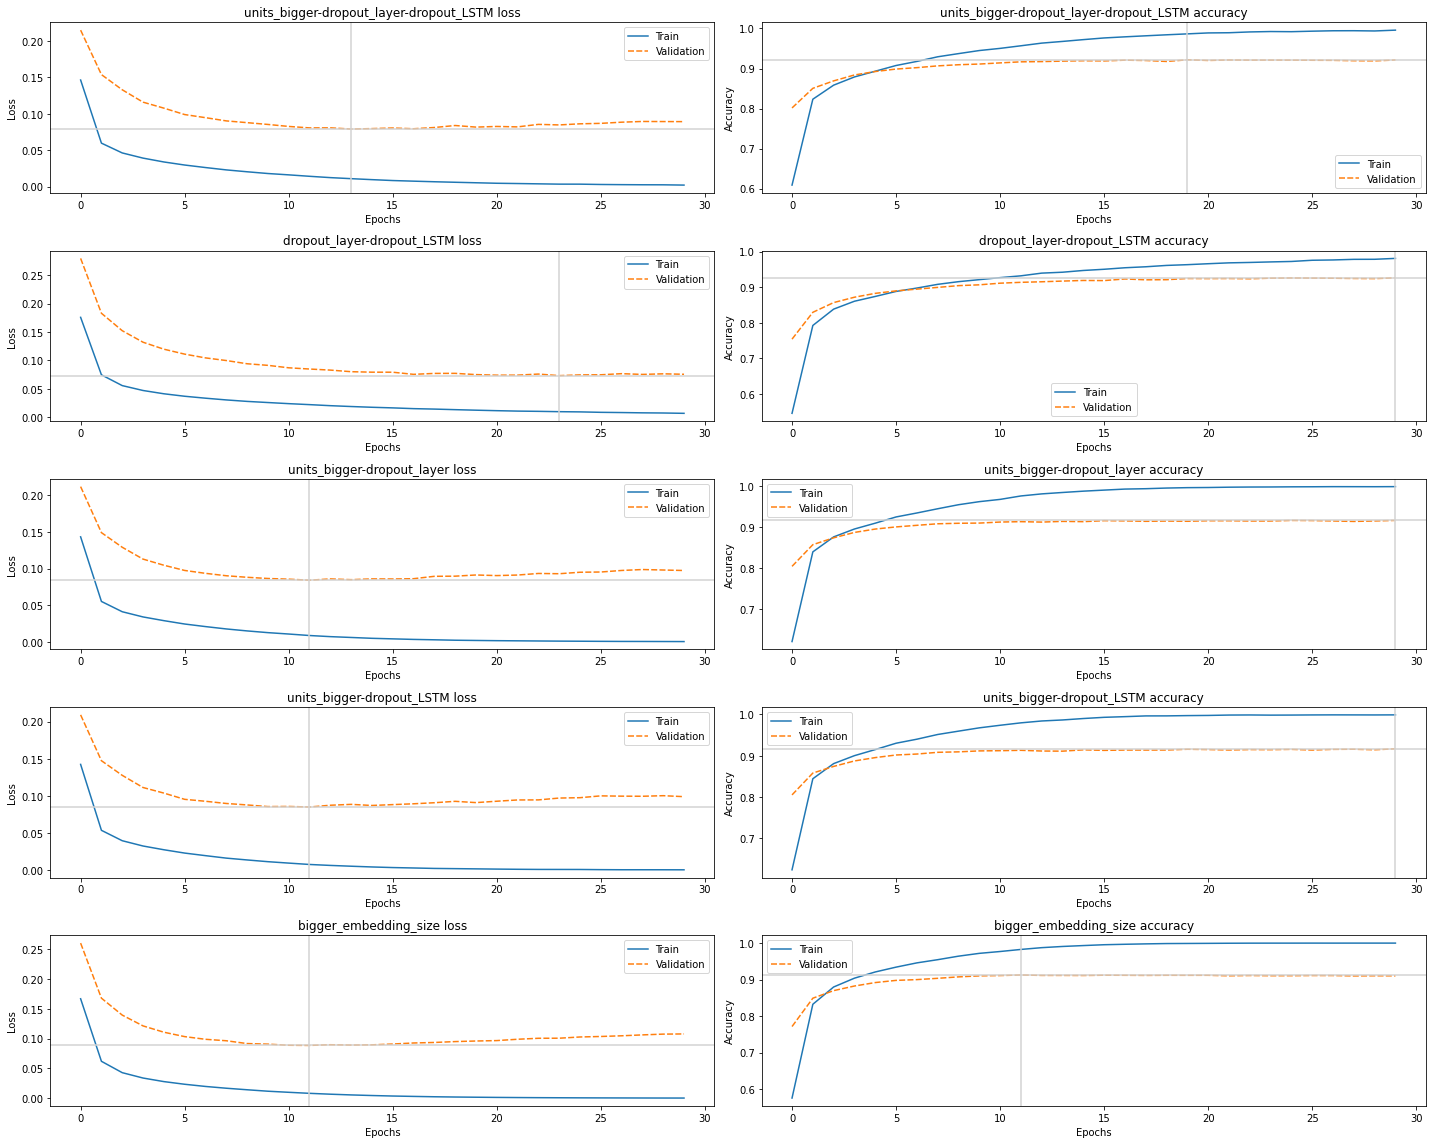

In [94]:
plot_history(final_models_history)

We can see that overfitting has been reduced. In particular the model with the smaller amount of LSTM hidden units is not overfitting at all, as validation loss remains stable and the maximum accuracy is in correspondence of the last epoch. This suggests that thi model might improve a bit more if trained for more epochs. Anyway, with this training, its performances in terms of f1-score are close to the ones of the best model.

# Final evaluation on the test set

In [95]:
f1_scores_test = {}

In [96]:
for model in best_two_models:
  f1_scores_test[model.name] = compute_f1(model,x_st["test"],y_cat["test"],punctuation_enc)
print()
for key, value in f1_scores_test.items():
  print(f"{key} model has f1-score on the test set equal to {value:.5}")

21/21 [==============================] - 3s 8ms/step

units_bigger-dropout_layer-dropout_LSTM model has f1-score on the test set equal to 0.8561
dropout_layer-dropout_LSTM model has f1-score on the test set equal to 0.86881


It is interesting to notice that dropout_layer-dropout_LSTM model, so the one with less LSTM hidden units performs better than the other best model, even though on validation set it was the other way around. 
As already mentioned, this suggests again that dropout_layer-dropout_LSTM model might improve and become the best one if trained for more epochs. 

# Error Analysis

## Analyzing performances on the five most and less frequent classes

We are going to compute f1-score on two subsets of pos labels, namely the 5-most-common and the 5-less-common ones. 

In [97]:
def find_classes_ordered_by_frequency(y_enc, 
                                      idx_to_label):  
    """
    Given the dictionary of encoded labels (y) and the mapping from indeces to pos labels, return the dictionaries of frequencies.

    :param 
        - y_enc: dictionary of encoded labels (for train, val, test)
        - idx_to_label: mapping from indeces to labels
    :return:
        - frequencies_enc: dictionary with key=encoded_label and value=frequency
        - frequencies_not_enc: dictionary with key=label_not_encoded and value=frequency
    """
    
    frequencies_enc = {}  #dictionary with key=pos_encoded and value=label_frequency
    for sentence in y_enc["train"] + y_enc["val"] + y_enc["test"]:
        for label in sentence:
            if label not in frequencies_enc.keys():
                frequencies_enc[label] = 0
            frequencies_enc[label] += 1
    frequencies_enc = {k: v for k, v in sorted(frequencies_enc.items(), key=lambda item: item[1], reverse=True)} 
    frequencies_not_enc = {idx_to_label[k]: v for k, v in frequencies_enc.items()}  #dictionary with key=pos_not_encoded and value=label_frequency
    
    return frequencies_enc, frequencies_not_enc

In [98]:
frequencies_enc, frequencies_not_enc = find_classes_ordered_by_frequency(y_enc, idx_to_label)

print(f"The classes with highest frequency are: {list(frequencies_not_enc.keys())[:5]}")
print(f"whose encodings are {list(frequencies_enc.keys())[:5]}\n")

print(f"The classes with lowest frequency are: {list(frequencies_not_enc.keys())[-5:]}")
print(f"whose encodings are {list(frequencies_enc.keys())[-5:]}")

The classes with highest frequency are: ['NN', 'IN', 'NNP', 'DT', 'NNS']
whose encodings are [9, 10, 1, 8, 4]

The classes with lowest frequency are: ['WP$', 'LS', 'FW', 'UH', 'SYM']
whose encodings are [36, 44, 41, 42, 43]


Computing the f1-score of the best model on the selected labels. Note that to compare results with the ones obtained before, we removed punctuation.

In [136]:
f1_scores_per_frequency = {"5-highest-frequency-pos": compute_f1(best_two_models[0],
                                                                 x_st["test"],
                                                                 y_cat["test"], 
                                                                 list(frequencies_enc.keys())[5:]+punctuation_enc,
                                                                 return_length=True), #excluding all the classes except for the 5 most freqent ones and also punctuation
                           "5-lowest-frequency-pos": compute_f1(best_two_models[0],
                                                                 x_st["test"],
                                                                 y_cat["test"], 
                                                                 list(frequencies_enc.keys())[:-5]+punctuation_enc,
                                                                 return_length=True)  #excluding all the classes except for the 5 less freqent ones and also punctuation
                          }

21/21 [==============================] - 0s 8ms/step
Number of samples after masking: 7793
21/21 [==============================] - 0s 7ms/step
Number of samples after masking: 4


In [137]:
for key, value in f1_scores_per_frequency.items():
    print(f"f1-score considering only the {key} is {value}")

f1-score considering only the 5-highest-frequency-pos is 0.9433453330314293
f1-score considering only the 5-lowest-frequency-pos is 1.0


Both the f1-scores are very high, but for different reasons.
Firstly, the more common labels have a far larger support, so the model had the chance to train on all the training examples and now performs well on the test set. 
On the other hand, the less common pos have a very small support, which makes them very specific. Due to this specificity, they might be very easy to classify for the model. 

## Precision and recall

We are going to compute precision and recall for the best model applied to the test set. This is useful to understand if f1-score is dominated by one of them or they both contribute to the quite high value reached on the test set.

In [101]:
def compute_precision_recall(model, x, y_true, punctuation):
    """
    Given a model, the data x to feed to the model, the ground truth labels and punctuation encodings, return precision and recall

    :param 
        - model: model to be used
        - x: input data (standardized version of the encoded sentences)
        - y_true: ground truth labels (one-hot-encoded)
        - punctuation: punctuation encodings to exclude from precision and recall computation
    :return:
        - precision and recall with macro average
    """
    y_true = np.argmax(y_true, axis=2).flatten()
    y_pred = np.argmax(model.predict(x), axis=2).flatten()
    
    mask = np.in1d(y_true, punctuation, invert=True)  #mask to exclude punctuation symbols
    unique_pos = [pos for pos in np.unique(np.concatenate((y_true, y_pred))) if not pos in punctuation]

    return (precision_score(y_true[mask], 
                    y_pred[mask], 
                    average='macro', 
                    labels=unique_pos, 
                    zero_division=0),   
            recall_score(y_true[mask], 
                    y_pred[mask], 
                    average='macro', 
                    labels=unique_pos, 
                    zero_division=0))

In [103]:
precision, recall = compute_precision_recall(best_two_models[0],
                                              x_st["test"],
                                              y_cat["test"], 
                                             punctuation_enc)
print(f"Precision on the test set is {precision}")
print(f"Recall on the test set is {recall}")

21/21 [==============================] - 0s 8ms/step
Precision on the test set is 0.8872764513131854
Recall on the test set is 0.8517887526522716


The values obtained for precision and recall on the test set are very close, which is the reason why we are able to get quite high f1-score too. 

## Confusion matrix

We are going to plot the confusion matrices of the best two models applied on the test set. 

In [138]:
def plot_confusion_matrix(model, x, y_true, punctuation, idx_to_label):
    
    """
    Given a model, the data x to feed to the model, the ground truth labels, punctuation encodings, labels and their mapping, plot confusion matrix

    :param 
        - model: model to be used
        - x: input data (standardized version of the encoded sentences)
        - y_true: ground truth labels (one-hot-encoded)
        - punctuation: punctuation encodings to exclude from f1-score computation
        - idx_to_label: mapping from indeces to labels
    :return:
        - cm: confusion matrix
    """
    y_true = np.argmax(y_true, axis=2).flatten()
    y_pred = np.argmax(model.predict(x), axis=2).flatten()
    
    mask = np.in1d(y_true, punctuation, invert=True)  #mask to exclude punctuation symbols
    unique_pos = [pos for pos in np.unique(y_true) if not pos in punctuation]

    fig, ax = plt.subplots(figsize=(15, 15))
    disp = ConfusionMatrixDisplay.from_predictions(y_true[mask],
                                                   y_pred[mask],
                                                   labels=unique_pos, 
                                                   normalize='true', 
                                                   display_labels=np.array([idx_to_label[label] for label in unique_pos]),
                                                   ax=ax, 
                                                   include_values=False
                                                  )
    plt.show()


21/21 [==============================] - 0s 8ms/step


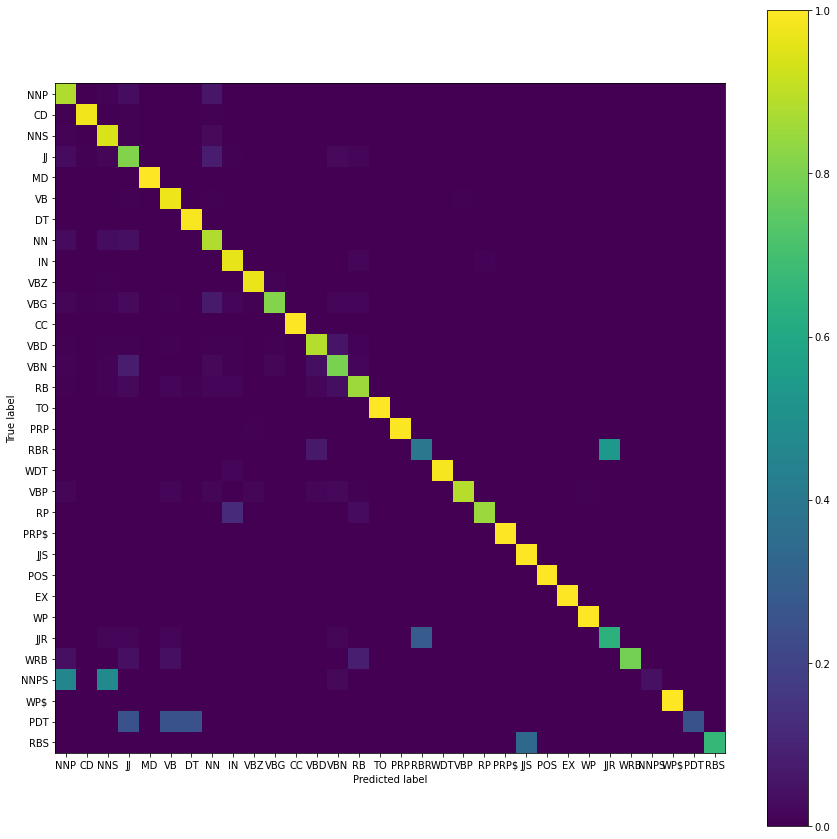

In [139]:
plot_confusion_matrix(best_two_models[0],
                      x_st["test"],
                      y_cat["test"], 
                      punctuation_enc,
                      idx_to_label
                      )

21/21 [==============================] - 0s 7ms/step


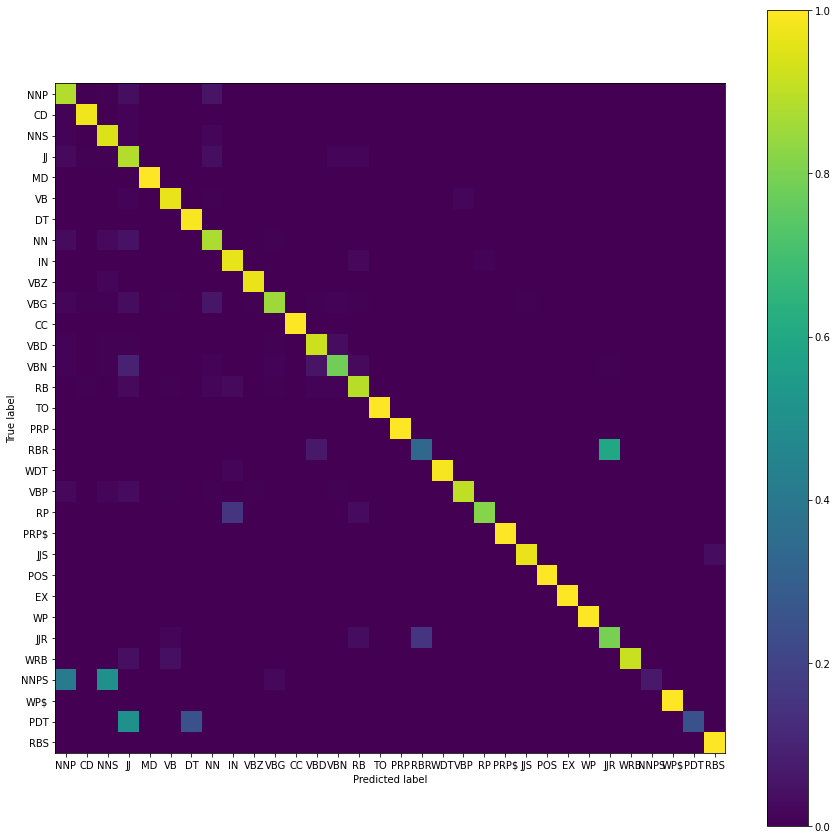

In [140]:
plot_confusion_matrix(best_two_models[1],
                      x_st["test"],
                      y_cat["test"], 
                      punctuation_enc,
                      idx_to_label
                      )

Inspecting the confusion matrices of the two models applied to the test set we can see that they have very similar performances. They work well on most of the classes, but have some problems at classifying some others, such as NNPS, PDT, RBR, JJR. According to hese results the class creating more problems is NNPS, which in most of the case is confused with NNP or NNS. 